# Bert with Rouge Evaluation

## Note: This is only one model we tried. Additional models are in the other notebooks that were submitted for Project Step 6.

Bert is an extractive text summarization algorithm that assigns scores to each sentence and evaluates their overall importance. The most important sentences become part of the summary.

Sources:
https://analyticsindiamag.com/hands-on-guide-to-extractive-text-summarization-with-bertsum/

https://pypi.org/project/rouge/#description

https://stats.stackexchange.com/questions/301626/interpreting-rouge-scores

https://www.researchgate.net/publication/220106310_Evaluation_Measures_for_Text_Summarization

### Installing the libraries

In [1]:
import nltk
import pandas as pd
nltk.download('stopwords')
from nltk.corpus import stopwords
from summarizer import Summarizer
from rouge import Rouge 

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import learning_curve

import matplotlib.pyplot as plt
from nltk.translate.bleu_score import sentence_bleu

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


ModuleNotFoundError: No module named 'summarizer'

In [ ]:
!pip install bert-extractive-summarizer

In [2]:
!pip install rouge

You should consider upgrading via the '/opt/conda/bin/python3 -m pip install --upgrade pip' command.


### Uploading and cleaning up the data

#### Articles is a DataFrame that contains the following:

author: The author of each article

date: The date each article was published

headlines: The headline of each article

read_more: The link leading to each article


text: The human summarized form of each article

ctext: The full articles

In [9]:
#en_stops = set(stopwords.words('english'))
 
articles = pd.read_csv("news_summary.csv", encoding = 'unicode_escape')
#articles

In [10]:
articles

,author,date,headlines,read_more,text,ctext
0,Chhavi Tyagi,"03 Aug 2017,Thursday",Daman & Diu revokes mandatory Rakshabandhan in...,http://www.hindustantimes.com/india-news/raksh...,The Administration of Union Territory Daman an...,The Daman and Diu administration on Wednesday ...
1,Daisy Mowke,"03 Aug 2017,Thursday",Malaika slams user who trolled her for 'divorc...,http://www.hindustantimes.com/bollywood/malaik...,Malaika Arora slammed an Instagram user who tr...,"From her special numbers to TV?appearances, Bo..."
2,Arshiya Chopra,"03 Aug 2017,Thursday",'Virgin' now corrected to 'Unmarried' in IGIMS...,http://www.hindustantimes.com/patna/bihar-igim...,The Indira Gandhi Institute of Medical Science...,The Indira Gandhi Institute of Medical Science...
3,Sumedha Sehra,"03 Aug 2017,Thursday",Aaj aapne pakad liya: LeT man Dujana before be...,http://indiatoday.intoday.in/story/abu-dujana-...,Lashkar-e-Taiba's Kashmir commander Abu Dujana...,Lashkar-e-Taiba's Kashmir commander Abu Dujana...
4,Aarushi Maheshwari,"03 Aug 2017,Thursday",Hotel staff to get training to spot signs of s...,http://indiatoday.intoday.in/story/sex-traffic...,Hotels in Maharashtra will train their staff t...,Hotels in Mumbai and other Indian cities are t...
...,...,...,...,...,...,...
4509,Mansha Mahajan,"24 Feb 2017,Friday",Rasna seeking ?250 cr revenue from snack categ...,http://indiatoday.intoday.in/story/rasna-eyes-...,Fruit juice concentrate maker Rasna is eyeing ...,"Mumbai, Feb 23 (PTI) Fruit juice concentrate m..."
4510,Dishant Sharma,"03 Aug 2017,Thursday",Sachin attends Rajya Sabha after questions on ...,http://indiatoday.intoday.in/story/sachin-tend...,Former Indian cricketer Sachin Tendulkar atten...,Former cricketer Sachin Tendulkar was spotted ...
4511,Tanya Dhingra,"03 Aug 2017,Thursday",Shouldn't rob their childhood: Aamir on kids r...,http://www.hindustantimes.com/bollywood/secret...,"Aamir Khan, while talking about reality shows ...","Aamir Khan, whose last film Dangal told the st..."
4512,Pragya Swastik,"07 Dec 2016,Wednesday","Asha Bhosle gets ?53,000 power bill for unused...",http://indiatoday.intoday.in/story/singer-asha...,The Maharashtra government has initiated an in...,Maharahstra Power Minister Chandrashekhar Bawa...


Duplicate articles and empty rows removed from dataset

In [47]:
articles = articles.drop_duplicates(ignore_index=True)
aritcles = articles.dropna(subset=['ctext'],inplace=True)
articles = articles.reset_index(drop=True)
articles

,author,date,headlines,read_more,text,ctext
0,Chhavi Tyagi,"03 Aug 2017,Thursday",Daman & Diu revokes mandatory Rakshabandhan in...,http://www.hindustantimes.com/india-news/raksh...,The Administration of Union Territory Daman an...,The Daman and Diu administration on Wednesday ...
1,Daisy Mowke,"03 Aug 2017,Thursday",Malaika slams user who trolled her for 'divorc...,http://www.hindustantimes.com/bollywood/malaik...,Malaika Arora slammed an Instagram user who tr...,"From her special numbers to TVappearances, Bol..."
2,Arshiya Chopra,"03 Aug 2017,Thursday",'Virgin' now corrected to 'Unmarried' in IGIMS...,http://www.hindustantimes.com/patna/bihar-igim...,The Indira Gandhi Institute of Medical Science...,The Indira Gandhi Institute of Medical Science...
3,Sumedha Sehra,"03 Aug 2017,Thursday",Aaj aapne pakad liya: LeT man Dujana before be...,http://indiatoday.intoday.in/story/abu-dujana-...,Lashkar-e-Taiba's Kashmir commander Abu Dujana...,Lashkar-e-Taiba's Kashmir commander Abu Dujana...
4,Aarushi Maheshwari,"03 Aug 2017,Thursday",Hotel staff to get training to spot signs of s...,http://indiatoday.intoday.in/story/sex-traffic...,Hotels in Maharashtra will train their staff t...,Hotels in Mumbai and other Indian cities are t...
...,...,...,...,...,...,...
4391,Mansha Mahajan,"24 Feb 2017,Friday",Rasna seeking ?250 cr revenue from snack categ...,http://indiatoday.intoday.in/story/rasna-eyes-...,Fruit juice concentrate maker Rasna is eyeing ...,"Mumbai, Feb 23 (PTI) Fruit juice concentrate m..."
4392,Dishant Sharma,"03 Aug 2017,Thursday",Sachin attends Rajya Sabha after questions on ...,http://indiatoday.intoday.in/story/sachin-tend...,Former Indian cricketer Sachin Tendulkar atten...,Former cricketer Sachin Tendulkar was spotted ...
4393,Tanya Dhingra,"03 Aug 2017,Thursday",Shouldn't rob their childhood: Aamir on kids r...,http://www.hindustantimes.com/bollywood/secret...,"Aamir Khan, while talking about reality shows ...","Aamir Khan, whose last film Dangal told the st..."
4394,Pragya Swastik,"07 Dec 2016,Wednesday","Asha Bhosle gets ?53,000 power bill for unused...",http://indiatoday.intoday.in/story/singer-asha...,The Maharashtra government has initiated an in...,Maharahstra Power Minister Chandrashekhar Bawa...


An example article, to determine what kind of cleanup needs to be done

In [12]:
test_article = articles['ctext'][0]
test_article

'The Daman and Diu administration on Wednesday withdrew a circular that asked women staff to tie rakhis on male colleagues after the order triggered a backlash from employees and was ripped apart on social media.The union territory?s administration was forced to retreat within 24 hours of issuing the circular that made it compulsory for its staff to celebrate Rakshabandhan at workplace.?It has been decided to celebrate the festival of Rakshabandhan on August 7. In this connection, all offices/ departments shall remain open and celebrate the festival collectively at a suitable time wherein all the lady staff shall tie rakhis to their colleagues,? the order, issued on August 1 by Gurpreet Singh, deputy secretary (personnel), had said.To ensure that no one skipped office, an attendance report was to be sent to the government the next evening.The two notifications ? one mandating the celebration of Rakshabandhan (left) and the other withdrawing the mandate (right) ? were issued by the Dama

Regex is used on the test article to replace stray question marks (in the dataset, many symbols were replaced with ?s).

In [13]:
import re
# help with only replacing part of regex
# https://stackoverflow.com/questions/39950775/regex-replace-only-a-part-of-the-match

test_article = re.sub(" \? ", " ", test_article)
test_article = re.sub(" \?", " ", test_article)
test_article = re.sub(r"\?( [a-z])", r"\1", test_article)
test_article = re.sub(r"\?([a-z])", r"\1", test_article)
test_article = re.sub("\.\?", ".", test_article)
test_article = re.sub("\?\.", ".", test_article)
test_article = re.sub(r"\.([A-Z])", r". \1", test_article)
test_article = re.sub(r"\?( [^A-Z])", r"\1", test_article)
test_article = re.sub(r"\?(\,)", r"\1", test_article)
#test_article = re.sub("\?.", "", test_article)
test_article

'The Daman and Diu administration on Wednesday withdrew a circular that asked women staff to tie rakhis on male colleagues after the order triggered a backlash from employees and was ripped apart on social media. The union territorys administration was forced to retreat within 24 hours of issuing the circular that made it compulsory for its staff to celebrate Rakshabandhan at workplace. It has been decided to celebrate the festival of Rakshabandhan on August 7. In this connection, all offices/ departments shall remain open and celebrate the festival collectively at a suitable time wherein all the lady staff shall tie rakhis to their colleagues, the order, issued on August 1 by Gurpreet Singh, deputy secretary (personnel), had said. To ensure that no one skipped office, an attendance report was to be sent to the government the next evening. The two notifications one mandating the celebration of Rakshabandhan (left) and the other withdrawing the mandate (right) were issued by the Daman a

In [14]:
test_article2 = articles['ctext'][1]
test_article2

'From her special numbers to TV?appearances, Bollywood actor Malaika Arora Khan has managed to carve her own identity. The actor, who made her debut in the Hindi film industry with the blockbuster debut opposite Shah Rukh Khan in Chaiyya Chaiyya from Dil Se (1998), is still remembered for the song. However, for trolls, she is a woman first and what matters right now is that she divorced a ?rich man?.  On Wednesday, Malaika Arora shared a gorgeous picture of herself on Instagram and a follower decided to troll her for using her ?alumni? (read alimony) money to wear ?short clothes and going to gym or salon?. Little did he/she know that the Munni Badnam star would reply with the perfect comeback. Take a look at the interaction:     Super excited to be affiliated with Khanna Jewellers @khannajewellerskj as their brand ambassador. Crafted to perfection, their stunning statement jewellery is a must have for every jewellery lover. #khannajewellers...#maksquad?? #hair @hairbypriyanka #stylist 

In [15]:
test_article2 = re.sub(" \? ", " ", test_article2)
test_article2 = re.sub(" \?", " ", test_article2)
test_article2 = re.sub(r"\?( [a-z])", r"\1", test_article2)
test_article2 = re.sub(r"\?([a-z])", r"\1", test_article2)
test_article2 = re.sub("\.\?", ".", test_article2)
test_article2 = re.sub("\?\.", ".", test_article2)
test_article2 = re.sub(r"\.([A-Z])", r". \1", test_article2)
test_article2 = re.sub(r"\?( [^A-Z])", r"\1", test_article2)
test_article2 = re.sub(r"\?(\,)", r"\1", test_article2)
test_article2

'From her special numbers to TVappearances, Bollywood actor Malaika Arora Khan has managed to carve her own identity. The actor, who made her debut in the Hindi film industry with the blockbuster debut opposite Shah Rukh Khan in Chaiyya Chaiyya from Dil Se (1998), is still remembered for the song. However, for trolls, she is a woman first and what matters right now is that she divorced a rich man.  On Wednesday, Malaika Arora shared a gorgeous picture of herself on Instagram and a follower decided to troll her for using her alumni (read alimony) money to wear short clothes and going to gym or salon. Little did he/she know that the Munni Badnam star would reply with the perfect comeback. Take a look at the interaction:     Super excited to be affiliated with Khanna Jewellers @khannajewellerskj as their brand ambassador. Crafted to perfection, their stunning statement jewellery is a must have for every jewellery lover. #khannajewellers...#maksquad? #hair @hairbypriyanka #stylist @manekah

In [16]:
len(test_article)

2307

### Bert Extractive Summarizer library - tested with test articles

In [17]:
model = Summarizer()
result = model(test_article, min_length=20)
summary = "".join(result)
print(summary)

Some weights of the model checkpoint at bert-large-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


The Daman and Diu administration on Wednesday withdrew a circular that asked women staff to tie rakhis on male colleagues after the order triggered a backlash from employees and was ripped apart on social media. The union territorys administration was forced to retreat within 24 hours of issuing the circular that made it compulsory for its staff to celebrate Rakshabandhan at workplace. In this connection, all offices/ departments shall remain open and celebrate the festival collectively at a suitable time wherein all the lady staff shall tie rakhis to their colleagues, the order, issued on August 1 by Gurpreet Singh, deputy secretary (personnel), had said. The circular is ridiculous.


In [18]:
model = Summarizer()
result = model(test_article, min_length=30)
summary = "".join(result)
print(summary)

Some weights of the model checkpoint at bert-large-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


The Daman and Diu administration on Wednesday withdrew a circular that asked women staff to tie rakhis on male colleagues after the order triggered a backlash from employees and was ripped apart on social media. The union territorys administration was forced to retreat within 24 hours of issuing the circular that made it compulsory for its staff to celebrate Rakshabandhan at workplace. In this connection, all offices/ departments shall remain open and celebrate the festival collectively at a suitable time wherein all the lady staff shall tie rakhis to their colleagues, the order, issued on August 1 by Gurpreet Singh, deputy secretary (personnel), had said. There are sensitivities involved.


In [19]:
model = Summarizer()
result = model(test_article, min_length=40)
summary = "".join(result)
print(summary)

Some weights of the model checkpoint at bert-large-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


The Daman and Diu administration on Wednesday withdrew a circular that asked women staff to tie rakhis on male colleagues after the order triggered a backlash from employees and was ripped apart on social media. The union territorys administration was forced to retreat within 24 hours of issuing the circular that made it compulsory for its staff to celebrate Rakshabandhan at workplace. In this connection, all offices/ departments shall remain open and celebrate the festival collectively at a suitable time wherein all the lady staff shall tie rakhis to their colleagues, the order, issued on August 1 by Gurpreet Singh, deputy secretary (personnel), had said.


### The Summarizer library from Bert uses an  extractive summarizing technique by utilizing pytorch transformers. Bert was originally trained, so we didn't proceed with any further training and strarted testing our data

We limited the dataset size to 200 articles.

In [22]:
articles['ctext'][30]

'Jammu and Kashmir police approached the Pakistan high commission in Delhi and asked them to claim the body of Lashkar-e-Taiba (LeT) divisional commander Abu Dujana, killed by the security forces on Tuesday.Munir Khan, Inspector General of Police (IGP) Kashmir told reporters on Tuesday that Pakistan high commission has been approached to claim the body of Dujana, who belonged to Gilgit-Baltistan area in Pakistan-administered part of Kashmir.This is for the first time the authorities have approached Pakistan high commission asking them to claim the body of any Pakistani national killed in anti-militancy operations in Jammu and Kashmir.?If they don?t claim his body, we will give him a proper burial,? the IGP said, adding that authorities wished Dujana?s parents should see their son before burial and for that reason the Commission had been approached.Police refused to hand over Dujana?s body to the civilians for burial. The senior police officer said ?there was no reason to hand over the 

Test pre-processing to remove odd characters

In [23]:
for i, article in enumerate(articles['ctext']):
    article = re.sub(" \? ", " ", article)
    article = re.sub(" \?", " ", article)
    article = re.sub(r"\?( [a-z])", r"\1", article)
    article = re.sub(r"\?([a-z])", r"\1", article)
    article = re.sub("\.\?", ".", article)
    article = re.sub("\?\.", ".", article)
    article = re.sub(r"\.([A-Z])", r". \1", article)
    article = re.sub(r"\?( [^A-Z])", r"\1", article)
    article = re.sub(r"\?(\,)", r"\1", article)
    article = re.sub(r"(\,)\?", r"\1", article)
    articles['ctext'][i] = article

In [24]:
articles['ctext'][100]

'There is only a 5% chance that the Earth will avoid warming by at least 2C come the end of the century, according to new research that paints a sobering picture of the international effort to stem dangerous climate change. Global trends in the economy, emissions and population growth make it extremely unlikely that the planet will remain below the 2C threshold set out in the Paris climate agreement in 2015, the study states. The Paris accord, signed by 195 countries, commits to holding the average global temperature to well below 2C above pre-industrial levels and sets a more aspirational goal to limit warming to 1.5C. This latter target is barely plausible, the new research finds, with just a 1% chance that temperatures will rise by less than 1.5C. Were closer to the margin than we think, said Adrian Raftery, a University of Washington academic who led the research, published in Nature Climate Change. If we want to avoid 2C, we have very little time left. The public should be very co

Bert Summarization done in batches

In [25]:
bert_summarized_articles = []
for i, article in enumerate(articles['ctext'][:50]):
    result = model(article, min_length=20)
    summary = "".join(result)
    print("\n " + str(i) + ". " + summary)
    bert_summarized_articles.append(summary)


 0. The Daman and Diu administration on Wednesday withdrew a circular that asked women staff to tie rakhis on male colleagues after the order triggered a backlash from employees and was ripped apart on social media. The union territorys administration was forced to retreat within 24 hours of issuing the circular that made it compulsory for its staff to celebrate Rakshabandhan at workplace. In this connection, all offices/ departments shall remain open and celebrate the festival collectively at a suitable time wherein all the lady staff shall tie rakhis to their colleagues, the order, issued on August 1 by Gurpreet Singh, deputy secretary (personnel), had said. The circular is ridiculous.

 1. From her special numbers to TVappearances, Bollywood actor Malaika Arora Khan has managed to carve her own identity. hair @hairbypriyanka #stylist @manekaharisinghani #manager @ektakauroberoi #mua @subbu28 #photographer @prasdnaik A post shared by Malaika Arora Khan (@malaikaarorakhanofficial) on

In [26]:
for i, article in enumerate(articles['ctext'][50:100], 50):
    result = model(article, min_length=20)
    summary = "".join(result)
    print("\n " + str(i) + ". " + summary)
    bert_summarized_articles.append(summary)


 50. A session court in Mumbai convicted 15 Somali pirates for 7 years of imprisonment in a 2011 case. They also captured the 15 Somali pirates who jumped into the sea and took them into custody.

 51. A teacher of a private school in Haridwar district has been accused of stripping two girls in front of the class for performing poorly in a test held for English subject, an allegation refuted by the school management. Whatever we have to say we have told the investigating police officer. District education officer (primary schools), Brahmpal Saini said that if such an incident had taken place, then it is quite shocking and a serious matter.

 52. New Delhi, Aug 2 (PTI) Successive governments have "short changed" Air India by treating it like their private properties, TMC leader Dinesh Trivedi said today as he urged the Centre to review the decision to divest stake in the airline. " Against this backdrop, Trivedi said it is evident that there is potential for further growth of Air India

In [27]:
for i, article in enumerate(articles['ctext'][100:151], 100):
    result = model(article, min_length=20)
    summary = "".join(result)
    print("\n " + str(i) + ". " + summary)
    bert_summarized_articles.append(summary)


 100. There is only a 5% chance that the Earth will avoid warming by at least 2C come the end of the century, according to new research that paints a sobering picture of the international effort to stem dangerous climate change. Global trends in the economy, emissions and population growth make it extremely unlikely that the planet will remain below the 2C threshold set out in the Paris climate agreement in 2015, the study states. The public should be very concerned. It negates the most optimistic outcome as well as the worst case, which would see temperatures climb nearly 6C beyond the pre-industrial era. Even if the 2C target isnt met, action is very important, said Raftery. But this research gives a false sense of rigor. If you look at technology adoption and action taken on the ozone layer and acid rain, its clear these things can change faster than people predict. Its like youre driving and about to collide with the car in front of you, he said.

 101. After a swarm of bees held 

In [28]:
for i, article in enumerate(articles['ctext'][151:201], 151):
    result = model(article, min_length=20)
    summary = "".join(result)
    print("\n " + str(i) + ". " + summary)
    bert_summarized_articles.append(summary)


 151. Archaeologists have unearthed a large, centuries-old statue that is believed to have once stood guard over an ancient hospital at Cambodias famed Angkor temple complex. Cambodian archaeologists and experts from Singapores Institute of Southeast Asian Studies found the statue buried 40 centimeters under the ground during an excavation of an Angkor-era hospital built during the reign of King Jayavarman VII.

 152. The Indian contingent of hearing impaired athletes, returning to the country after its best ever performance in the Deaflympics -- clinching five medals, including a gold -- refused to leave the Indira Gandhi International Airport in New Delhi on Tuesday morning (5 a.m.) after realising that not a single official from the Sports Authority of India (SAI) or the sports ministry were present to welcome them. Out of those eight disciplines, we won medals in three. ANI Digital (@ani_digital) August 1, 2017The SAI official then took the players to Jawaharlal Nehru Stadium and 

###  A new DataFrame that groups the output summarized text from our model and the original and summarized text from our dataset

In [29]:
articles_subset = pd.DataFrame(articles['ctext'][:201])
articles_subset['summarized'] = bert_summarized_articles
articles_subset['text'] = articles['text'][:201]
articles_subset

,ctext,summarized,text
0,The Daman and Diu administration on Wednesday ...,The Daman and Diu administration on Wednesday ...,The Administration of Union Territory Daman an...
1,"From her special numbers to TVappearances, Bol...","From her special numbers to TVappearances, Bol...",Malaika Arora slammed an Instagram user who tr...
2,The Indira Gandhi Institute of Medical Science...,The Indira Gandhi Institute of Medical Science...,The Indira Gandhi Institute of Medical Science...
3,Lashkar-e-Taiba's Kashmir commander Abu Dujana...,Lashkar-e-Taiba's Kashmir commander Abu Dujana...,Lashkar-e-Taiba's Kashmir commander Abu Dujana...
4,Hotels in Mumbai and other Indian cities are t...,Hotels in Mumbai and other Indian cities are t...,Hotels in Maharashtra will train their staff t...
...,...,...,...
196,Bollywood actor Shahid Kapoor says his upcomin...,Bollywood actor Shahid Kapoor says his upcomin...,Shahid Kapoor said he went mad on Twitter afte...
197,Akshay Kumar never fails to impress his co-sta...,Akshay Kumar never fails to impress his co-sta...,Bhumi Pednekar has said that Akshay Kumar is d...
198,Prime Minister Narendra Modi has time and agai...,Prime Minister Narendra Modi has time and agai...,The Modi government is planning to launch a cr...
199,Opposition Congress said in Rajya Sabha on Mon...,Opposition Congress said in Rajya Sabha on Mon...,Congress on Monday informed Rajya Sabha that R...


In [30]:
articles_subset['ctext'][0]

'The Daman and Diu administration on Wednesday withdrew a circular that asked women staff to tie rakhis on male colleagues after the order triggered a backlash from employees and was ripped apart on social media. The union territorys administration was forced to retreat within 24 hours of issuing the circular that made it compulsory for its staff to celebrate Rakshabandhan at workplace. It has been decided to celebrate the festival of Rakshabandhan on August 7. In this connection, all offices/ departments shall remain open and celebrate the festival collectively at a suitable time wherein all the lady staff shall tie rakhis to their colleagues, the order, issued on August 1 by Gurpreet Singh, deputy secretary (personnel), had said. To ensure that no one skipped office, an attendance report was to be sent to the government the next evening. The two notifications one mandating the celebration of Rakshabandhan (left) and the other withdrawing the mandate (right) were issued by the Daman a

In [31]:
articles_subset['summarized'][0]

'The Daman and Diu administration on Wednesday withdrew a circular that asked women staff to tie rakhis on male colleagues after the order triggered a backlash from employees and was ripped apart on social media. The union territorys administration was forced to retreat within 24 hours of issuing the circular that made it compulsory for its staff to celebrate Rakshabandhan at workplace. In this connection, all offices/ departments shall remain open and celebrate the festival collectively at a suitable time wherein all the lady staff shall tie rakhis to their colleagues, the order, issued on August 1 by Gurpreet Singh, deputy secretary (personnel), had said. The circular is ridiculous.'

In [32]:
articles_subset['text'][0]

'The Administration of Union Territory Daman and Diu has revoked its order that made it compulsory for women to tie rakhis to their male colleagues on the occasion of Rakshabandhan on August 7. The administration was forced to withdraw the decision within 24 hours of issuing the circular after it received flak from employees and was slammed on social media.'

In [33]:
articles_subset['ctext'][100]

'There is only a 5% chance that the Earth will avoid warming by at least 2C come the end of the century, according to new research that paints a sobering picture of the international effort to stem dangerous climate change. Global trends in the economy, emissions and population growth make it extremely unlikely that the planet will remain below the 2C threshold set out in the Paris climate agreement in 2015, the study states. The Paris accord, signed by 195 countries, commits to holding the average global temperature to well below 2C above pre-industrial levels and sets a more aspirational goal to limit warming to 1.5C. This latter target is barely plausible, the new research finds, with just a 1% chance that temperatures will rise by less than 1.5C. Were closer to the margin than we think, said Adrian Raftery, a University of Washington academic who led the research, published in Nature Climate Change. If we want to avoid 2C, we have very little time left. The public should be very co

In [34]:
articles_subset['summarized'][100]

'There is only a 5% chance that the Earth will avoid warming by at least 2C come the end of the century, according to new research that paints a sobering picture of the international effort to stem dangerous climate change. Global trends in the economy, emissions and population growth make it extremely unlikely that the planet will remain below the 2C threshold set out in the Paris climate agreement in 2015, the study states. The public should be very concerned. It negates the most optimistic outcome as well as the worst case, which would see temperatures climb nearly 6C beyond the pre-industrial era. Even if the 2C target isnt met, action is very important, said Raftery. But this research gives a false sense of rigor. If you look at technology adoption and action taken on the ozone layer and acid rain, its clear these things can change faster than people predict. Its like youre driving and about to collide with the car in front of you, he said.'

In [35]:
articles_subset['text'][100]

'According to a recently published US-based research, there is only a 5% chance that Earth will avoid warming by at least 2°C by 2100, the threshold set in the Paris climate agreement. The research studied global trends in the economy, emissions and population growth, and further stated that there is 1% chance that temperatures will rise by less than 1.5°C.'

In [36]:
articles_subset.to_csv('articles_with_bert_sum.csv')

In [37]:
articles_subset = pd.read_csv("articles_with_bert_sum.csv")

In [38]:
articles_subset = articles_subset.drop(columns=['Unnamed: 0'])

In [39]:
articles_subset

,ctext,summarized,text
0,The Daman and Diu administration on Wednesday ...,The Daman and Diu administration on Wednesday ...,The Administration of Union Territory Daman an...
1,"From her special numbers to TVappearances, Bol...","From her special numbers to TVappearances, Bol...",Malaika Arora slammed an Instagram user who tr...
2,The Indira Gandhi Institute of Medical Science...,The Indira Gandhi Institute of Medical Science...,The Indira Gandhi Institute of Medical Science...
3,Lashkar-e-Taiba's Kashmir commander Abu Dujana...,Lashkar-e-Taiba's Kashmir commander Abu Dujana...,Lashkar-e-Taiba's Kashmir commander Abu Dujana...
4,Hotels in Mumbai and other Indian cities are t...,Hotels in Mumbai and other Indian cities are t...,Hotels in Maharashtra will train their staff t...
...,...,...,...
196,Bollywood actor Shahid Kapoor says his upcomin...,Bollywood actor Shahid Kapoor says his upcomin...,Shahid Kapoor said he went mad on Twitter afte...
197,Akshay Kumar never fails to impress his co-sta...,Akshay Kumar never fails to impress his co-sta...,Bhumi Pednekar has said that Akshay Kumar is d...
198,Prime Minister Narendra Modi has time and agai...,Prime Minister Narendra Modi has time and agai...,The Modi government is planning to launch a cr...
199,Opposition Congress said in Rajya Sabha on Mon...,Opposition Congress said in Rajya Sabha on Mon...,Congress on Monday informed Rajya Sabha that R...


Tried evaluating with BLEU. However, BLEU is mainly used for the evaluation of abstractive summarization methods, and this is an extractive summarization method.

Source: https://machinelearningmastery.com/calculate-bleu-score-for-text-python/#:~:text=BLEU%2C%20or%20the%20Bilingual%20Evaluation,of%20natural%20language%20processing%20tasks.

https://www.rws.com/blog/understanding-mt-quality-bleu-scores/

In [42]:

candidate = tok_summary_clean
reference = [tok_set_summary_clean]
score = sentence_bleu(reference, candidate)
print(score)

0.1934441876179681


In [45]:

hypothesis = articles_subset['summarized']
reference = articles_subset['text']
rouge = Rouge()
scores = rouge.get_scores(hypothesis, reference, avg=True)

In [46]:
scores

{'rouge-1': {'r': 0.46120795780388274,
  'p': 0.3391248089900854,
  'f': 0.37980868724632055},
 'rouge-2': {'r': 0.21858757878330787,
  'p': 0.15906850780853418,
  'f': 0.17797635639647572},
 'rouge-l': {'r': 0.4200224702323303,
  'p': 0.3087853052815164,
  'f': 0.34582496483875563}}

In [48]:
rouge1_r_cumulative = 0
rouge1_p_cumulative = 0
rouge1_f_cumulative = 0

rouge2_r_cumulative = 0
rouge2_p_cumulative = 0
rouge2_f_cumulative = 0

rougel_r_cumulative = 0
rougel_p_cumulative = 0
rougel_f_cumulative = 0

for i in range(len(articles_subset)):
    hypothesis = articles_subset['summarized'][i]
    reference = articles_subset['text'][i]
    rouge = Rouge()
    scores = rouge.get_scores(hypothesis, reference, avg=True)
    rouge1_r_cumulative += scores['rouge-1']['r']
    rouge1_p_cumulative += scores['rouge-1']['p']
    rouge1_f_cumulative += scores['rouge-1']['f']
    
    rouge2_r_cumulative += scores['rouge-2']['r']
    rouge2_p_cumulative += scores['rouge-2']['p']
    rouge2_f_cumulative += scores['rouge-2']['f']
    
    rougel_r_cumulative += scores['rouge-l']['r']
    rougel_p_cumulative += scores['rouge-l']['p']
    rougel_f_cumulative += scores['rouge-l']['f']

rouge1_r_average = rouge1_r_cumulative / len(articles_subset)
rouge1_p_average = rouge1_p_cumulative / len(articles_subset)
rouge1_f_average = rouge1_f_cumulative / len(articles_subset)

rouge2_r_average = rouge2_r_cumulative / len(articles_subset)
rouge2_p_average = rouge2_p_cumulative / len(articles_subset)
rouge2_f_average = rouge2_f_cumulative / len(articles_subset)

rougel_r_average = rougel_r_cumulative / len(articles_subset)
rougel_p_average = rougel_p_cumulative / len(articles_subset)
rougel_f_average = rougel_f_cumulative / len(articles_subset)

Average rouge scores for all article summaries. (r is recall, p is precision, f is the f1 score)

rouge-1: unigram overlap

rouge-2: bigram overlap

rouge-l: Longest matching sequence of words between the bert (generated) summary and the reference summary using LCS

In [49]:
print("Average rouge-1 r: ", rouge1_r_average)
print("Average rouge-1 p: ", rouge1_p_average)
print("Average rouge-1 f: ", rouge1_f_average, "\n")
# rouge one is similarity of words in the target and summary

print("Average rouge-2 r: ", rouge2_r_average)
print("Average rouge-2 p: ", rouge2_p_average)
print("Average rouge-2 f: ", rouge2_f_average, "\n")
# rouge two is how many pairs of the words did you get from the target
# "joe really loves data science" - ex.(joe really , really loves, loves data)

print("Average rouge-l r: ", rougel_r_average)
print("Average rouge-l p: ", rougel_p_average)
print("Average rouge-l f: ", rougel_f_average)
# rouge l how many words are in a correct order from the target

Average rouge-1 r:  0.46120795780388274
Average rouge-1 p:  0.3391248089900854
Average rouge-1 f:  0.37980868724632055 

Average rouge-2 r:  0.21858757878330787
Average rouge-2 p:  0.15906850780853418
Average rouge-2 f:  0.17797635639647572 

Average rouge-l r:  0.4200224702323303
Average rouge-l p:  0.3087853052815164
Average rouge-l f:  0.34582496483875563


Rouge evaluates the similarity of the Bert model generated summaries to the summaries that were generated by humans in the dataset. While Bert-generated summaries may be very different than the human-generated summaries, this does not necessarily mean that they are significantly worse. It is difficult to quantitatively evaluate text summarization.

###  A plot that cross refrences the length of each text before and after summarization

In [52]:
len(articles['ctext'][0])

2307

In [53]:
len(articles_subset['summarized'][0])

692

In [54]:
articles_len = articles['ctext'].apply(len)
articles_len = [articles_len[:201]]
articles_len

[0      2307
 1      2370
 2      2100
 3      2388
 4      3260
        ... 
 196    2042
 197    2105
 198    1577
 199    1613
 200    3074
 Name: ctext, Length: 201, dtype: int64]

In [55]:
summarized_len = articles_subset['summarized'].apply(len)
summarized_len = [summarized_len]
summarized_len

[0      692
 1      622
 2      477
 3      525
 4      530
       ... 
 196    452
 197    557
 198    359
 199    446
 200    851
 Name: summarized, Length: 201, dtype: int64]

Lengths of summaries:

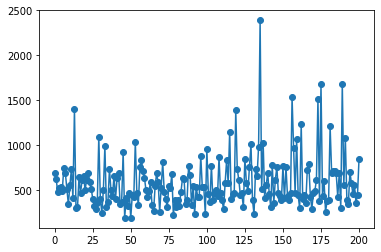

In [58]:
plt.plot(articles_subset['summarized'].apply(len),  marker="o", label = 'summarized articles')

Lengths of full articles:

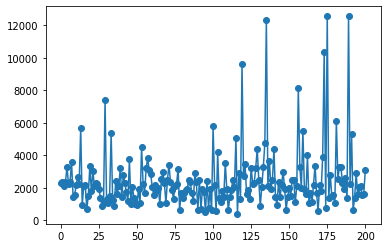

In [59]:
plt.plot(articles['ctext'].apply(len)[:201],  marker="o", label = 'raw articles text')

The plots above present a comparison between the lengths of the full articles and the lengths of their summarizes.